<a href="https://colab.research.google.com/github/alex00324/Coursera-KAggle/blob/main/notebook3cf4219201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Coursera** : ***Final Proyect Kaggles***

This is the first step we must load the libraries that we are going to use but for this we install the versions we need of them.


In [57]:

!pip install numpy==1.14.2
!pip install pandas==0.25.0
!pip install sklearn==0.19.1
!pip install scipy==0.19.1
!pip install lightgbm==2.1.0
!pip install seaborn==0.8.0

ERROR: Could not find a version that satisfies the requirement sklearn==0.19.1 (from versions: 0.0)
ERROR: No matching distribution found for sklearn==0.19.1


In [58]:
import numpy as np
import pandas as pd
import sklearn
import scipy.sparse 
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
# settings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(15, 7)})

review package versions

In [59]:
for p in [np, pd, sklearn, scipy, lgb, sns]:
    print (p.__name__, p.__version__)

numpy 1.14.2
pandas 0.25.0
sklearn 0.22.2.post1
scipy 0.19.1
lightgbm 2.1.0
seaborn 0.8.0


Import Files 

In [30]:
from google.colab import files
files.upload()

Saving best_lgb.sav to best_lgb.sav
Saving best_rf.sav to best_rf.sav
Saving best_rf_2.pkl to best_rf_2.pkl
Saving funs.py to funs.py
Saving item_categories.csv to item_categories.csv
Saving items.csv to items.csv
Saving sales_train.csv.gz to sales_train.csv.gz
Saving sample_submission.csv to sample_submission.csv
Saving shops.csv to shops.csv
Saving test.csv to test.csv


We import the functions

In [8]:

from funs import downcast_dtypes, rmse,  get_feature_matrix, clip20, clip40

we load the data that we previously uploaded

In [9]:
shops = pd.read_csv('shops.csv')
sales = pd.read_csv('sales_train.csv.gz')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv')

Exploratory Data Analaysis

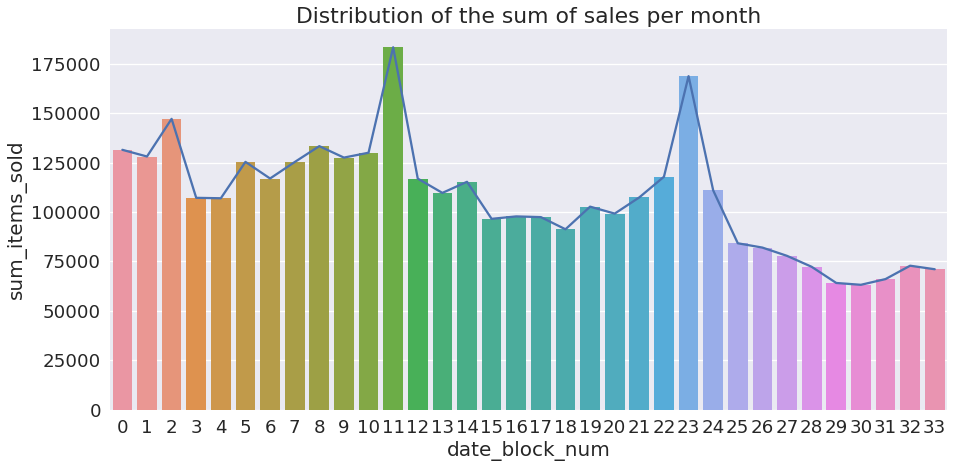

In [10]:
sns.set_context("talk", font_scale=1.4)
sales_month = pd.DataFrame(sales.groupby(['date_block_num']).sum().item_cnt_day).reset_index()
sales_month.columns = ['date_block_num', 'sum_items_sold']
sns.barplot(x ='date_block_num', y='sum_items_sold', 
            data=sales_month.reset_index());
plt.plot(sales_month.sum_items_sold)
plt.title('Distribution of the sum of sales per month')
del sales_month

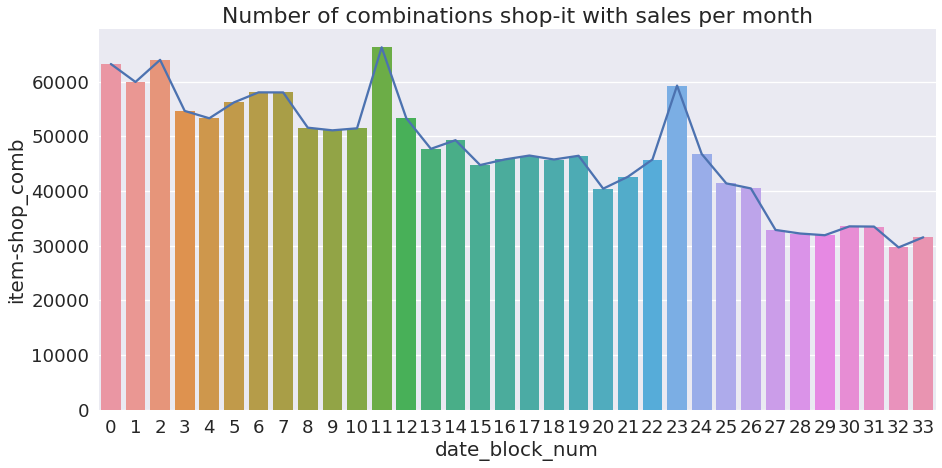

In [11]:
comb_shop_item = pd.DataFrame(sales[['date_block_num', 'shop_id', 
                                     'item_id']].drop_duplicates().groupby('date_block_num').size()).reset_index()
comb_shop_item.columns = ['date_block_num', 'item-shop_comb']
sns.barplot(x ='date_block_num', y='item-shop_comb', data=comb_shop_item);
plt.plot(comb_shop_item['item-shop_comb']);
plt.title('Number of combinations shop-it with sales per month')
del comb_shop_item

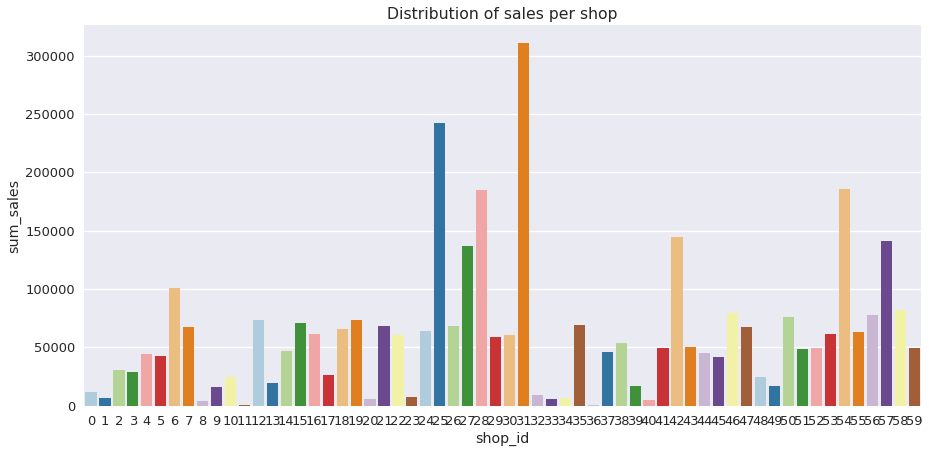

In [12]:
sns.set_context("talk", font_scale=1)
sales_month_shop_id = pd.DataFrame(sales.groupby(['shop_id']).sum().item_cnt_day).reset_index()
sales_month_shop_id.columns = ['shop_id', 'sum_sales']
sns.barplot(x ='shop_id', y='sum_sales', data=sales_month_shop_id, palette='Paired')
plt.title('Distribution of sales per shop');
del sales_month_shop_id

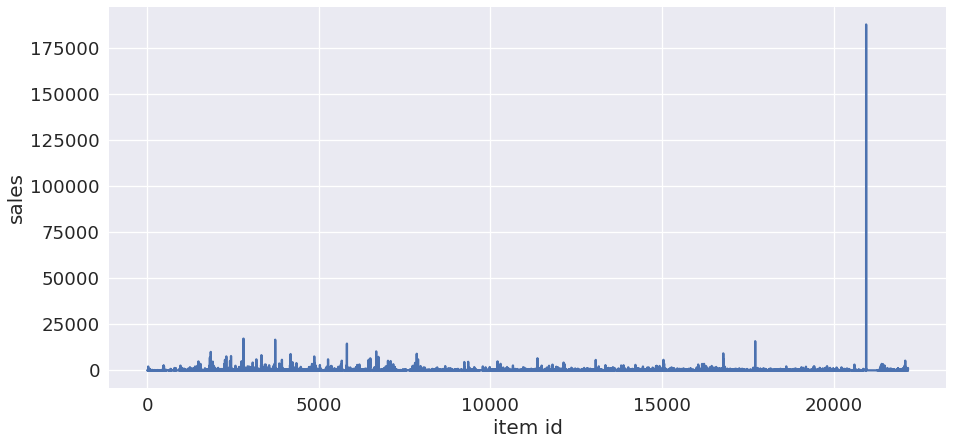

In [13]:
sns.set_context("talk", font_scale=1.4)
sales_item_id = pd.DataFrame(sales.groupby(['item_id']).sum().item_cnt_day)
plt.xlabel('item id')
plt.ylabel('sales')
plt.plot(sales_item_id);

In [14]:
anomaly_item = sales_item_id.item_cnt_day.argmax()
anomaly_item

20949

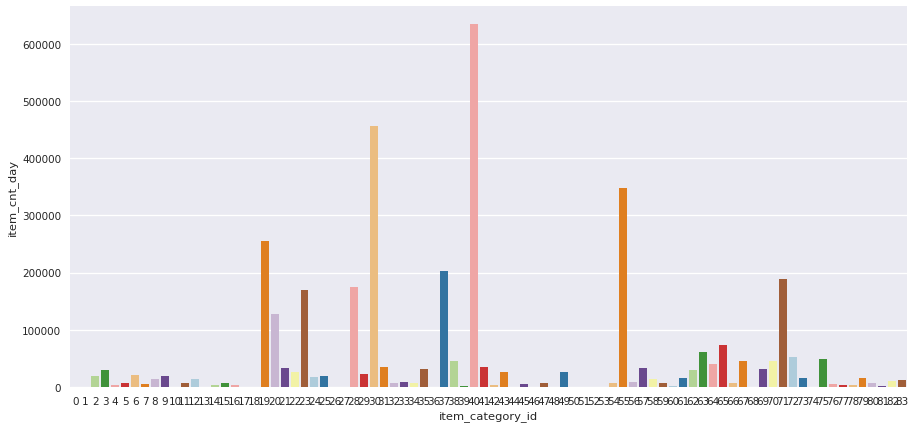

In [15]:
sns.set_context("talk", font_scale=0.8)
sales_item_cat = sales.merge(items, how='left', on='item_id').groupby('item_category_id').item_cnt_day.sum()
sns.barplot(x ='item_category_id', y='item_cnt_day',
            data=sales_item_cat.reset_index(), 
            palette='Paired'
           );
del sales_item_cat

In [16]:

tuples_df = pd.Series(list(sales[['item_id', 'shop_id']].itertuples(index=False, name=None)))
tuples_test = pd.Series(list(test[['item_id', 'shop_id']].itertuples(index=False, name=None)))
print(str(round(tuples_df.isin(tuples_test).sum()/len(tuples_df),2)*100)+'%')

42.0%


In [17]:
list_lags = [1, 2, 3]
date_block_threshold = 12
sales_for_modelling = sales[sales.item_id.isin(test.item_id)]
[all_data, to_drop_cols]  = get_feature_matrix(sales_for_modelling, test, items, list_lags, date_block_threshold)

In [18]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id
0,54,10297,12,4.0,3416.0,23.0,3.0,42.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,37
1,54,10298,12,14.0,3416.0,182.0,21.0,369.0,4282.0,119.0,1309.0,3085.0,7.0,144.0,2464.0,40
2,54,10300,12,3.0,3416.0,26.0,1.0,54.0,4282.0,31.0,361.0,3085.0,0.0,53.0,2464.0,37
3,54,10292,12,9.0,3416.0,93.0,8.0,156.0,4282.0,16.0,203.0,3085.0,15.0,279.0,2464.0,40
4,54,10143,12,1.0,3416.0,12.0,1.0,18.0,4282.0,0.0,2.0,3085.0,0.0,0.0,0.0,55


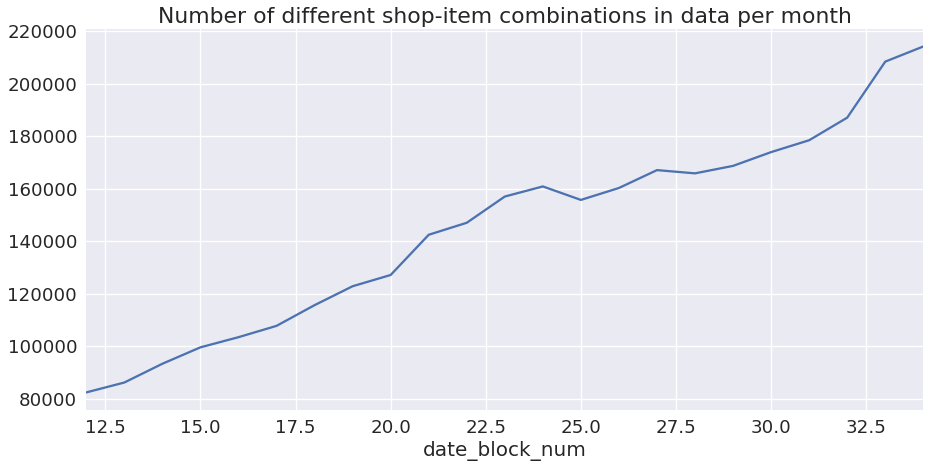

In [19]:

sns.set_context("talk", font_scale=1.4)
plt.title('Number of different shop-item combinations in data per month')
all_data.groupby('date_block_num').size().plot();

In [20]:
mean_enc_item_cat = pd.DataFrame(all_data.groupby(['shop_id', 
                                                    'item_category_id']).target.agg(['mean', 'var']).reset_index())
mean_enc_item_cat.columns = ['shop_id', 'item_category_id', 'mean_enc_cat_id', 'var_enc_cat_id']
all_data = pd.merge(all_data, mean_enc_item_cat, how='left', on=['shop_id', 'item_category_id'])
del mean_enc_item_cat
all_data = downcast_dtypes(all_data)

***Train/  dev/test split strategy***

In [21]:
sub_data = all_data[all_data.date_block_num==34].fillna(0)
all_data = all_data[all_data.date_block_num<34].fillna(0)
sub_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,item_category_id,mean_enc_cat_id,var_enc_cat_id
3110574,5,5037,34,0.0,0.0,0.0,0.0,25.0,1032.0,1.0,110.0,1041.0,3.0,119.0,1218.0,19,0.663426,2.329000
3110575,5,5320,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,0.223282,0.406817
3110576,5,5233,34,0.0,0.0,0.0,1.0,42.0,1032.0,3.0,80.0,1041.0,1.0,150.0,1218.0,19,0.663426,2.329000
3110577,5,5232,34,0.0,0.0,0.0,0.0,28.0,1032.0,0.0,48.0,1041.0,1.0,65.0,1218.0,23,0.465819,1.079278
3110578,5,5268,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1.095659,11.922459


In [22]:
dates = all_data['date_block_num']
boolean_test = (dates.isin([22,31,32,33]))
boolean_train = ~boolean_test
dates_train = dates[boolean_train]
dates_val  = dates[boolean_test]

X_train = all_data.loc[boolean_train].drop(to_drop_cols, axis=1)
X_val =  all_data.loc[boolean_test].drop(to_drop_cols, axis=1)

y_train = all_data.loc[boolean_train, 'target'].values
y_val =  all_data.loc[boolean_test, 'target'].values

In [23]:
tuples_validation_submission = pd.Series(list(X_val[['item_id', 'shop_id']][dates_val==33].itertuples(index=False, name=None)))
print(f'The {round(tuples_test.isin(tuples_validation_submission).sum()/len(tuples_test),2)*100} % of the item_id-shop_id are in the cv set ')

The 93.0 % of the item_id-shop_id are in the cv set 


Modelling with stacking

In [74]:

lgb = pickle.load(open('best_lgb.sav', 'rb'))
rf = pickle.load(open('best_rf.sav', 'rb'))


In [41]:
pred_lgb_val = lgb.predict(X_val)
print('Train RMSE for lgb is  %f' % rmse(clip20(y_train), clip20(lgb.predict(X_train))))
print('Val RMSE for lgb is %f' % rmse(clip20(y_val), clip20(pred_lgb_val)))

Train RMSE for lgb is  0.838416
Val RMSE for lgb is 0.805686


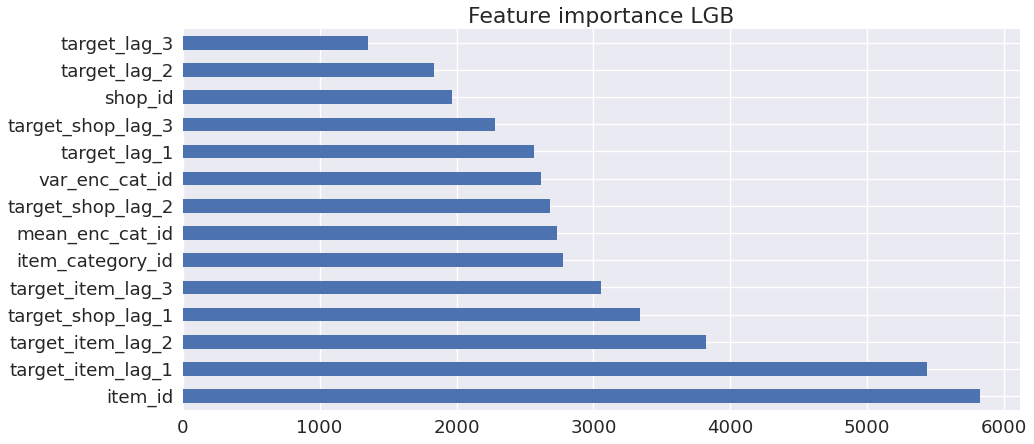

In [42]:
feat_importances = pd.Series(lgb.feature_importance(), index=X_val.columns)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')
plt.title('Feature importance LGB')
plt.show()

In [43]:

pred_rf_val = clip20(rf.predict(X_val.fillna(0)))
print('Train RMSE for rf is %f' % rmse(clip20(y_train), clip20(rf.predict(X_train))))
print('Val RMSE for rf is %f' % rmse(clip20(y_val), pred_rf_val))

Train RMSE for rf is 1.456770
Val RMSE for rf is 1.392405


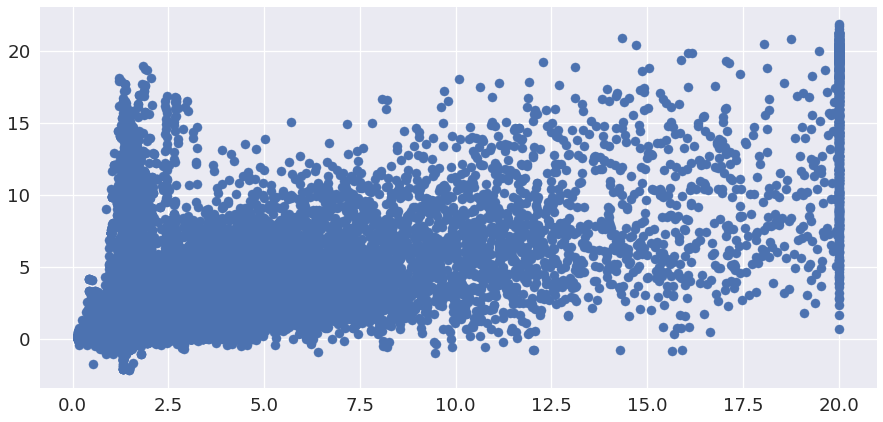

In [47]:
plt.scatter(pred_rf_val, pred_lgb_val)

In [75]:
X_val_level2 = np.c_[pred_rf_val, pred_lgb_val]

In [76]:
lr = LinearRegression()
lr.fit(X_val_level2, clip40(y_val))
pred_lr_val =  clip20(lr.predict(X_val_level2))
print('Test rmse for stacking variables is %f' % rmse(clip20(y_val), clip20(pred_lr_val)))

Test rmse for stacking variables is 0.802814


In [78]:
pred_test_rf = rf.predict(sub_data.drop(to_drop_cols, axis=1).fillna(0))
pred_test_lgb = lgb.predict(sub_data.drop(to_drop_cols, axis=1).fillna(0))
X_test_level2 = np.c_[pred_test_rf, pred_test_lgb]
test_pred = clip20(lr.predict(X_test_level2))
test_pred.mean()

0.3723961659277334

Submission

In [79]:
predictions = pd.DataFrame()
predictions['shop_id'] = test.shop_id
predictions['item_id'] = test.item_id
predictions['item_cnt_month'] = test_pred
submision = test[['ID', 'shop_id', 'item_id']].merge(predictions, on=['shop_id', 'item_id'], how='left').fillna(0)
submision[['ID', 'item_cnt_month']].to_csv('submission.csv',index=False)